In [1]:
pip install virtualenv
!virtualenv --version
#!pip3 install -r requirements.txt 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### First, lets gather all the data for each activity type together

In [2]:
def reader(type_t,n):    
    df_whole = pd.DataFrame()
    for i in range (1,n):
        temp = pd.read_csv('data/'+type_t+'/'+type_t+'-'+str(i)+'.csv') # reading csv file that lies in the data folder in the same dir
        temp.index.name = 'state'
        temp['obs'] = i-1
        temp.set_index('obs',append=True,inplace=True)
        temp = temp.reorder_levels(['obs', 'state'])
        df_whole = pd.concat((df_whole,temp),axis = 0)
    return df_whole

In [3]:
activities = ['idle','running','stairs','walking']
ens = [1040,3409,166,1851]

In [4]:
df_idle = reader(activities[0],ens[0])
df_running = reader(activities[1],ens[1])
df_stairs = reader(activities[2],ens[2])
df_walking = reader(activities[3],ens[3])

In [5]:
df_idle # mb would be better to agg it all together from the very beginning, as Im about to do that in future anyway..

accelerometer_X  accelerometer_Y  accelerometer_Z
obs  state                                                   
0    0             1.000776         4.616021         8.576031
     1             0.718261         4.209007         8.446744
     2            -0.909797        -0.282516         9.203311
     3             5.099650         0.148441         8.418014
     4             1.762132        -0.162806         9.251195
...                     ...              ...              ...
1038 25            1.292869         6.641516         7.958327
     26            0.636858         6.311116         7.354988
     27           -0.402226         5.382166         8.810662
     28           -0.177171         4.692636         8.394072
     29            2.437297         6.780380         7.163452

[31170 rows x 3 columns]

### Also, lets try to read that xml file

In [6]:
!pip install pandas_read_xml
import pandas_read_xml as pdx

In [7]:
df_xml = pdx.read_xml('AndroSensorSettings.xml')

In [8]:
df_xml.head() # cool, but useless=)

,AndroSensorSettings
accelerometercoord,1
active_sensors,locXXXaccXXXproXXXtim
baraltitude,disabled
csvformat,","
decimalpoints,6


### Ok, lets do some preparations and explorations now

In [9]:
df_idle['status'] = 1
df_running['status'] = 2
df_stairs['status'] = 3
df_walking['status'] = 4 # giving every status its number for further classification

In [10]:
def extract(df):
    lst = []
    for i in range(len(df.index.levels[0])):
        lst.append(df.loc[i,:].values)
    return lst

In [11]:
subjects_lst = extract(df_idle) + extract(df_running) + extract(df_stairs) + extract(df_walking)

In [12]:
len(subjects_lst) # putting all the observations in the format of numpy array in one list, mb it will come in handy

6462

In [13]:
subjects_lst[3000] # looks like this

array([[  4.97994 ,  -4.276044,  -2.542642,   2.      ],
       [  0.3304  ,   8.628703,   0.56982 ,   2.      ],
       [ -1.49877 ,  10.01734 ,  -1.958457,   2.      ],
       [ 17.592594,  16.730682,  -0.914585,   2.      ],
       [ -5.051765,   9.433155,  -1.288081,   2.      ],
       [  4.180277,  -5.267244,  -5.262455,   2.      ],
       [  1.733402,   6.344635,   1.206678,   2.      ],
       [ -0.675165,   2.39899 ,  -6.861782,   2.      ],
       [  6.220136,  21.796812,   5.425261,   2.      ],
       [ -3.308787,   7.182606,  -5.832275,   2.      ],
       [  3.155558, -28.3665  ,  -8.542512,   2.      ],
       [  6.550536,   5.406108,  -0.842759,   2.      ],
       [  6.124368,  23.99469 ,  10.43872 ,   2.      ],
       [  1.728614,  -1.862689,  -4.084508,   2.      ],
       [ -3.351882,   7.206548,   3.940856,   2.      ],
       [  3.969586,   4.146757,  -3.289633,   2.      ],
       [  4.817134,  -6.703765,  -2.255338,   2.      ],
       [ -0.3304  ,   3.040636,

In [14]:
one_person_move = np.vstack((subjects_lst[1500], subjects_lst[10],subjects_lst[4500], subjects_lst[5500],subjects_lst[100],subjects_lst[1600]))

In [ ]:
one_person_move # let that be theoretically some random person movement for 3 minutes (each state lasted for 30 sec as the data says)
# running --> idle --> stairs --> walking --> idle --> running

In [16]:
def plot_smth(sub):
    plt.figure(figsize=(10,9))
    for col in range(sub.shape[1]):
        plt.subplot(sub.shape[1], 1, col+1)
        plt.plot(sub[:,col],color = 'red')
    plt.show()

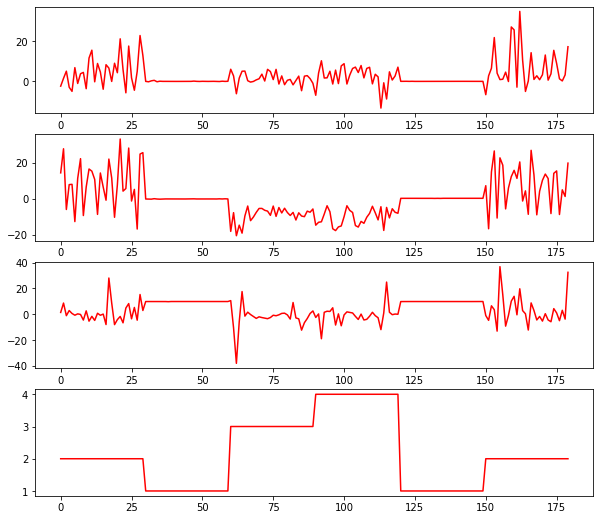

In [17]:
plot_smth(one_person_move) # just some additional visualizations

 The chart above let us see the way the real accelerometer data looks like, with the clear change of states and coordinates 

In [18]:
df = pd.concat((df_idle,df_running,df_stairs,df_walking),axis=0)
df = df.reset_index().drop(columns=['obs','state'])
ids = []
for j in range(int(len(df)/30)):  # a little bit of 'kostyls' for making it look as good as never
    for i in range(30):
        ids.append(j)
df['person id'] = ids    
df.set_index('person id',inplace=True)  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FD40AB4190>]],
      dtype=object)

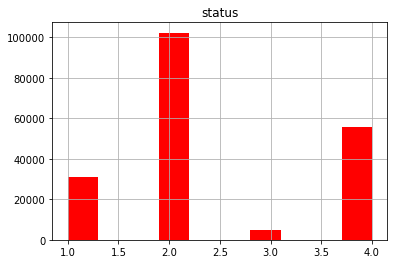

In [20]:
df.hist('status',color = 'red') # thats the distribution of the activities btw, most of the data related to the running

In [47]:
df.status.value_counts()

2    102240
4     55500
1     31170
3      4950
Name: status, dtype: int64

The simpliest classifier can be built with the use of the distribution above: 
the random observation (which technically consists of 30 observations) can be given its activity type value with some probability, which corresponds to the probability of each activity type being occured in data

In [49]:
t2proba,t4proba,t1proba,t3proba = 102240/len(df),55500/len(df),31170/len(df),4950/len(df)

In [50]:
t2proba # for example with prob of 52% every observation will be given an activity type 'running' and so on

0.5273909006499535

In [71]:
t2proba*1000,t4proba*1000,t1proba*1000,t3proba*1000

(527.3909006499536, 286.2890745899103, 160.7861343237388, 25.5338904363974)

In [77]:
import random
from sklearn.metrics import classification_report, accuracy_score

In [91]:
ys_true = df.iloc[::30, :].status

In [78]:
def pseudo_random_classifier():
    y_rand_pred = []
    for i in range(len(ys_true)):
        num = random.randrange(1000)
        if 0<=num<527: # 2nd activity has 52% chance
            y_rand_pred.append(2)
        elif 527<=num<813:
            y_rand_pred.append(4) #28% for 4th 
        elif 813<=num<973:
            y_rand_pred.append(1)
        else: y_rand_pred.append(3)
    return y_rand_pred      

In [121]:
y_rand = pseudo_random_classifier()
random.shuffle(ys_true) # shuffle y_true so it wont be ordered

In [122]:
print(classification_report(ys_true,y_rand))
print(f'accuracy score is {100*accuracy_score(ys_true,y_rand):.2f}%')

              precision    recall  f1-score   support

           1       0.17      0.17      0.17      1039
           2       0.53      0.53      0.53      3408
           3       0.04      0.05      0.05       165
           4       0.30      0.30      0.30      1850

    accuracy                           0.39      6462
   macro avg       0.26      0.26      0.26      6462
weighted avg       0.39      0.39      0.39      6462

accuracy score is 39.38%


Ok, lets consider this thing a 'classifier' and try to beat it with smth better =)

### Now its time for some data science

In [ ]:
"""
The thing here, is that i wanted to use some plain aggregated data to build simple knn model, and then improve the result by adding 
more feature etc. However, even the first 'plain' model showed very good accuracy, bruh.
"""

In [ ]:
indeces = [*range(6462)] # cause data is ordered in some bad way, we cannot just shuffle and use train-test split, that will break person id
train_indeces = [i for i in indeces if i%3 != 0]
test_indeces = [i for i in indeces if i%3 == 0] 

In [22]:
df_train = df[df.index.isin(train_indeces)]  # so I performed train/test split like this, still ok
df_test = df[df.index.isin(test_indeces)]

In [23]:
from sklearn.preprocessing import RobustScaler # why using robust instead of a plain scaler? it's robust - it's cooler

In [ ]:
cols = df.columns[:-1]
scaler = RobustScaler().fit(df_train[cols])
df_train.loc[:,cols] = scaler.transform(df_train[cols]) # scaled the data 
df_test.loc[:,cols] = scaler.transform(df_test[cols])

In [25]:
df_train_t = df_train.groupby('person id').mean() # we used mean value on every accelerometer coordinate of 30 obs (for one person) as a feature
df_test_t = df_test.groupby('person id').mean()

In [26]:
X_train, y_train, X_test, y_test = df_train_t[cols].values, df_train_t.status.values, df_test_t[cols].values, df_test_t.status.values

In [27]:
from sklearn.neighbors import KNeighborsClassifier # gonna use this thing for classification

In [28]:
classifier = KNeighborsClassifier(n_neighbors=5) # taking 5 neighbors here 'cause why not
classifier.fit(X_train,y_train)

KNeighborsClassifier()

In [29]:
y_pred = classifier.predict(X_test)

In [31]:
print(classification_report(y_test,y_pred)) # well, this stuff is already a beast!
print(f'accuracy score is {100*accuracy_score(y_test,y_pred):.2f}%')

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       347
           2       1.00      1.00      1.00      1136
           3       0.88      0.65      0.75        55
           4       0.97      0.99      0.98       616

    accuracy                           0.99      2154
   macro avg       0.96      0.91      0.93      2154
weighted avg       0.99      0.99      0.99      2154

accuracy score is 98.89%


### The accuracy is great, but it is too simple by now - lets try ... feature engineering!

In [ ]:
'''
Which features can be usefull? The internet says that these guys will help me here:

Range: The acceleration amplitude
--------------------------------------------------------------------------
Mean: The average value of the magnitude samples over a time window (always 30 in our case)
--------------------------------------------------------------------------
Variance: Average of the squared differences of the sample values from the mean value over a time window.
--------------------------------------------------------------------------
Root Mean Square (RMS): The root mean square is the square root of the sums of each data over a window, divided by the sample size.
--------------------------------------------------------------------------
Zero-Crossing Rate (ZCR):The number of points where a signal crosses through a specific value corresponding to half of 
the signal range. 
--------------------------------------------------------------------------
Absolute  Difference (ABSDIFF): Sum of the differences from between each magnitude sample and the mean of that window 
divided by the number of data points. 
--------------------------------------------------------------------------
First 5-FFT Coefficients: the first 5 of the fast-Fourier transform coefficients are taken since they capture the main frequency components.
(i guess i messed up with fft coefs (see below), so i didnt use this one)
'''


In [33]:
from math import sqrt
from scipy.fft import fft, ifft

In [34]:
def I_am_engineer(df):
    result = pd.DataFrame()
    some_random_counter = 0
    for i,g in df.groupby('person id'): #grouping by the same id and collect the features
        zero_patient = g
        rang = []
        mean = []
        var = []
        rms = []
        zcr = []
        absdiff = []
        fft5 = []
        for z in zero_patient.columns[:-1]:
            what_i_need = zero_patient[z]
            rang.append(abs(max(what_i_need)-min(what_i_need))) # range
            mean.append(np.mean(what_i_need)) # mean
            var.append(np.var(what_i_need)) # var
            rms.append(np.sqrt(abs(sum(what_i_need)))/what_i_need.size) # square root of sum divided on amount of samples 
            cross_point = (min(what_i_need)+max(what_i_need))/2
            zcr_counter = 0
            is_under = False if what_i_need.iloc[0]>cross_point else True # some simple logic to catch median point crossing
            for i in range(1,what_i_need.size):
                if what_i_need.iloc[i]>cross_point and is_under == True:
                    is_under = False
                    zcr_counter +=1
                elif what_i_need.iloc[i]<cross_point and is_under == False:
                    is_under = True
                    zcr_counter +=1
                else: pass
            zcr.append(zcr_counter) # number of crosses
            absdiff.append(sum([i-np.mean(what_i_need) for i in what_i_need])/what_i_need.size) #sum of value minus mean divided on sample size
            #fft5.append(ifft(fft(what_i_need.values))[:5]) #first 5 FFT coefs, something went wrong, aint using it
            
        features_values = rang+mean+var+rms+zcr+absdiff+list(zero_patient['status'])
        features_names = ['x range', 'y range', 'z range','x mean', 'y mean', 'z mean', 'x var', 'y var', 'z var', 'x rms', 'y rms', 'z rms',\
                 'x zcr', 'y zcr', 'z zcr','x abs', 'y abs', 'z abs','activity type']
        dicki_johns = {i:j for i,j in zip(features_names,features_values)} # dict with all i need
        
        result = pd.concat((result,pd.DataFrame(dicki_johns,index = [some_random_counter])),axis=0) 
        some_random_counter+=1
    return result

In [35]:
mr_dataframe = I_am_engineer(df)

In [36]:
mr_dataframe # well thats alot of (numbers) features, hope they are usefull enough

,x range,y range,z range,x mean,y mean,z mean,x var,y var,z var,x rms,y rms,z rms,x zcr,y zcr,z zcr,x abs,y abs,z abs,activity type
0,6.009447,4.898537,1.388636,0.178448,0.167435,9.605697,1.038242,1.295378,0.160051,0.077125,0.074707,0.565853,2,1,3,-2.405483e-17,0.000000e+00,-1.184238e-16,1
1,6.009447,0.430957,1.388636,0.113166,-0.135352,9.690771,1.007678,0.005451,0.074906,0.061418,0.067169,0.568353,2,4,2,-1.184238e-16,-2.590520e-17,-5.329071e-16,1
2,2.082955,0.268151,0.555455,-0.034636,-0.139343,9.755414,0.125810,0.002034,0.009344,0.033978,0.068152,0.570246,1,8,1,-2.775558e-18,-1.387779e-17,-1.065814e-15,1
3,0.727837,0.268151,0.138863,-0.098960,-0.137587,9.772653,0.014548,0.002022,0.000572,0.057434,0.067722,0.570750,2,8,2,-6.013708e-18,2.266705e-17,1.006602e-15,1
4,0.727837,0.268151,0.138863,-0.098322,-0.134075,9.771216,0.014882,0.002111,0.000622,0.057249,0.066852,0.570708,2,9,3,1.850372e-18,-6.013708e-18,2.486900e-15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6457,34.438196,31.253910,24.234110,-0.140300,-9.673852,-2.604891,32.089108,36.784210,41.056529,0.068386,0.567857,0.294669,6,16,12,-8.881784e-17,1.302662e-15,-1.776357e-16,4
6458,34.438196,31.253910,24.234110,-0.092576,-9.694282,-2.349510,34.051545,36.643400,40.911474,0.055550,0.568456,0.279852,6,15,11,7.401487e-17,1.953993e-15,2.072416e-16,4
6459,34.438196,31.253910,23.745694,0.326569,-9.496362,-1.819434,35.125860,35.618804,32.648722,0.104334,0.562624,0.246268,6,15,10,-1.480297e-16,8.585725e-16,8.141636e-17,4
6460,34.438196,31.253910,23.745694,0.903253,-9.713595,-1.823903,37.577583,34.326439,32.339091,0.173518,0.569022,0.246570,6,15,10,-2.072416e-16,-1.450691e-15,5.921189e-17,4


In [37]:
from sklearn.model_selection import train_test_split #now we can use the normal split

In [38]:
X = mr_dataframe[mr_dataframe.columns[:-1]].values
y = mr_dataframe['activity type'].values

In [148]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.2, random_state=2)

In [149]:
from sklearn.preprocessing import StandardScaler #try standart scaler this time

In [150]:
scaler = StandardScaler().fit(X_train_new)
X_train_new = scaler.transform(X_train_new)
X_test_new = scaler.transform(X_test_new)

In [151]:
classifier_new = KNeighborsClassifier(n_neighbors=15) # same 5
classifier_new.fit(X_train_new,y_train_new)

KNeighborsClassifier(n_neighbors=15)

In [152]:
y_pred_new = classifier_new.predict(X_test_new)
print(classification_report(y_test_new,y_pred_new)) 
print(f'accuracy score is {100*accuracy_score(y_test_new,y_pred_new):.2f}%')

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       207
           2       1.00      1.00      1.00       698
           3       0.95      0.61      0.75        31
           4       0.97      1.00      0.98       357

    accuracy                           0.99      1293
   macro avg       0.98      0.90      0.93      1293
weighted avg       0.99      0.99      0.99      1293

accuracy score is 98.99%


Well, the accuracy aint even alot better now!

As the possible improvement options, one may add more complicated features, but it wont have much impact after all. The n_neighbors param also can be better here I suppose (however, I've tried a couple and 5 seems the best for me so far)

Also there might be slightly better model with even 100% acc, but Im not sure)

In [ ]:
pip freeze > requirements.txt